# Script for process archival spectra.

The script do next steps for archival spectra reduction (calibration files)
* opens, 
* rotates, 
* aligns calibration frames,
* calculate polynomials for converting from optical density to relative intensity.

<span style="color:darkgreen">**For more information please find tutorial and necessary files on [GitHub repo](https://github.com/ill-i/Spectra-Reduction)**</span>

## Libraries

In comments you will see version of some libraries

In [1]:
# Core scientific computing libraries
import numpy as np  # NumPy for numerical operations, v1.20.3
from numpy.polynomial.polynomial import Polynomial  # For polynomial operations
import scipy  # SciPy for scientific and technical computing, v1.7.1
from scipy import signal  # For signal processing tasks
from scipy.signal import chirp, find_peaks, peak_widths, peak_prominences  # For signal analysis
from scipy.optimize import curve_fit, least_squares, leastsq, fsolve  # For optimization tasks
from scipy.ndimage import label, gaussian_filter  # For image labeling and filtering
from scipy.interpolate import interp1d  # For interpolation

from sklearn.linear_model import (
    LinearRegression,
    TheilSenRegressor,
    RANSACRegressor,
    HuberRegressor,
)
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.isotonic import IsotonicRegression

# Data manipulation and analysis libraries
import pandas as pd  # Pandas for data analysis (version not specified)
import re  # Regular expressions for string operations
from collections import Counter  # For counting hashable objects

# Astronomical data handling
import astropy  # Astropy for astronomy-related tasks, v4.3.1
from astropy.io import fits  # FITS file handling
from astropy.time import Time  # For handling time objects
from astropy.coordinates import SkyCoord  # For celestial coordinate system conversions
import astropy.units as u  # For unit conversions

# Image processing and visualization libraries
import cv2  # OpenCV for computer vision, v4.5.5
from PIL import Image  # Python Imaging Library, v8.4.0
from skimage import io, color, measure  # Scikit-Image for image processing, v0.18.3
from skimage.transform import hough_circle, hough_circle_peaks  # For Hough circle transforms
from skimage.feature import canny  # For edge detection
from skimage.draw import circle_perimeter  # For drawing circle perimeters
from skimage.util import img_as_ubyte  # For image type conversion
import matplotlib.pyplot as plt  # Matplotlib for data visualization, v3.4.3
from matplotlib import rcParams  # Matplotlib configuration settings

# Statistical and mathematical libraries
import math  # Basic mathematical operations
import statistics  # Basic statistical operations
from scipy import stats  # Statistical functions from SciPy
import hillfit  # Custom library for fitting (version not specified)

# Basic utilities and file operations
import os
import sys
import shutil
import string

import copy

from datetime import datetime


## Params for graphs

In [3]:
# for pretty plotting
rcParams['ps.fonttype']=42
rcParams['pdf.fonttype']=42
rcParams['font.size']=14
#rcParams['text.usetex']=True
rcParams['text.usetex'] = False  # Disable TeX rendering
rcParams['pgf.texsystem']='pdflatex'
rcParams['font.family']='DejaVu Sans'
rcParams['font.serif']='cm'
rcParams['text.latex.preamble']=r'\usepackage[T2A]{fontenc}'
#rcParams['text.latex.preamble'] = r'\usepackage[T2A]{fontenc}\usepackage{type1cm}'

## Known data for reduction

In [5]:
#the first and last values of the steps are the same, so we will use for calculations
#only the first 8 steps, but it should be remembered that there are 9 of them in total
mag_before_1972 = [0,0.61,1.1,1.47,1.84,2.25,2.66,3.04,0][:-1]
mag_after_1972 = [0,0.5,0.97,1.44,1.93,2.43,2.69,3.04,0][:-1]

## Functions

### Function for calibration frames reduction

#### Rotate and crop with mask

In [9]:
def rotate_and_crop_with_auto_mask(image,title=None):
    image_gray = np.array((image - np.min(image)) / (np.max(image) - np.min(image)) * 255, dtype=np.uint8)
    _, mask = cv2.threshold(image_gray, np.mean(image_gray) * 0.5, 255, cv2.THRESH_BINARY_INV)
    mask_contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    largest_contour = max(mask_contours, key=cv2.contourArea)
    rect = cv2.minAreaRect(largest_contour)
    center, size, angle = rect
    rows, cols = image.shape[:2] 
    M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
    rotated_image = cv2.warpAffine(image, M, (cols, rows))
    rotated_mask = cv2.warpAffine(mask, M, (cols, rows))
    
    crop_left, crop_right, crop_top, crop_bottom = calculate_crop_amounts(image, angle)
    #print(crop_left, crop_right, crop_top, crop_bottom )
    # Если изображение полностью пустое (что маловероятно), вернуть исходные
    cropped_image = rotated_image[crop_top:crop_bottom,crop_left:crop_right]
    cropped_mask = rotated_mask[crop_top:crop_bottom,crop_left:crop_right]
    #plt.imshow(cropped_mask)
    cropped_image = crop_calib(cropped_mask,cropped_image)
    plt.figure()
    plt.imshow(cropped_image)
    plt.title(title)
    return cropped_image


def calculate_crop_amounts(image, angle):
    # Размеры исходного изображения
    h, w = image.shape[:2]
    # Угол в радианах
    angle_rad = np.deg2rad(angle)
    # Вычисление размеров охватывающего прямоугольника
    cos_angle = abs(np.cos(angle_rad))
    sin_angle = abs(np.sin(angle_rad))
    new_w = int((h * sin_angle) + (w * cos_angle))
    new_h = int((h * cos_angle) + (w * sin_angle))
    # Расчет областей для обрезки
    crop_top = (new_h - h) // 2
    crop_bottom = crop_top
    crop_left = (new_w - w) // 2
    crop_right = crop_left
    
    return crop_left, w-crop_right, crop_top, h-crop_bottom


def find_nonzero_sequences(arr):
    
    length = len(arr)
    threshold = 20#int(0.05 * length)  # 10% от длины массива
    
    start_index = 0
    end_index = 0

    # Поиск с начала массива
    for i in range(length - threshold):
        if arr[i] != 0 and all(value != 0 for value in arr[i:i + threshold]):
            start_index = i
            break  # Прерываем цикл, как только найдем подходящую последовательность

    # Поиск с конца массива
    for i in range(length - 1, threshold - 1, -1):
        if arr[i] != 0 and all(value != 0 for value in arr[i - threshold + 1:i + 1]):
            end_index = i
            break  # Прерываем цикл, как только найдем подходящую последовательность
    plt.figure()
    plt.plot(arr)
    plt.axvline(start_index)
    plt.axvline(end_index)
    
    return int(start_index), int(end_index)

def crop_calib(mask,calib):
    
    columns = mask.sum(axis=0)
    rows = mask.sum(axis=1)
    
    start_index_col, end_index_col = find_nonzero_sequences(columns)
    start_index_col = int(start_index_col*.9)
    end_index_col =  int(end_index_col + (len(columns) - end_index_col)*.1)
    plt.figure()
    plt.plot(columns)
    plt.axvline(start_index_col)
    plt.axvline(end_index_col)
    plt.plot("Columns")
    start_index_row, end_index_row = find_nonzero_sequences(rows)
    start_index_row = int(start_index_row*1.2)
    end_index_row = int(end_index_row-(len(rows)-end_index_row)*.2)
    plt.figure()
    plt.plot(rows)
    plt.axvline(start_index_row)
    plt.axvline(end_index_row)
    plt.title("rows")
    print(start_index_row,end_index_row, start_index_col,end_index_col)
    calib_croped = calib[start_index_row:end_index_row, start_index_col:end_index_col]
    plt.figure()
    plt.imshow(calib_croped)
    return calib_croped

#### Rotate and crop with machine vision

In [14]:
def rotate_spectra_machine_vision(data,padding=20):
    """
    Processes and rotates a spectral data image to align it based on its largest contour,
    filtering smaller noise contours, and optionally cropping the image around the region of interest.

    Inputs:
    data : ndarray
        The 2D array of spectral image data to be processed and rotated.

    Output:
    data_cropped : ndarray
        The processed, rotated, and optionally cropped spectral image data.

    Steps:
    1. Create a binary mask from the original data where values below 75% of the mean are considered background.
    2. Convert the binary mask into a BGR color image for visualization and contour detection.
    3. Find contours in the binary mask, calculate their average size, and filter out smaller ones.
    4. Calculate the minimum enclosing rectangle for the filtered contours to identify the region of interest.
    5. Draw this rectangle on the color image for visualization.
    6. Find the largest contour and calculate the angle needed to align it horizontally.
    7. Rotate both the binary mask and the original data by this angle to align the spectral features.
    8. Optionally, crop the rotated images to focus on the region around the largest contour with some padding.
    9. Display and return the cropped area of the rotated original data.

    Notes:
    - The rotation corrects for any tilt in the spectral features, based on the largest feature detected.
    - Cropping is applied to both the mask and original data to ensure they remain aligned.
    - The function uses global rotation and cropping parameters; adjustments may be needed for different data sets.
    """
    # Binary thresholding based on mean intensity
    data_mask = np.where(data < np.mean(data) * .75, 255, 0).astype(np.uint8)

    # Convert to color image for visualization
    color_image = cv2.cvtColor(data_mask, cv2.COLOR_GRAY2BGR)

    # Contour detection and filtering
    contours, _ = cv2.findContours(data_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    average_size = np.mean([cv2.contourArea(contour) for contour in contours])
    filtered_contours = [contour for contour in contours if cv2.contourArea(contour) > average_size / 2]

    # Find the region of interest based on filtered contours
    min_x, min_y, max_x, max_y = np.inf, np.inf, -np.inf, -np.inf
    for contour in filtered_contours:
        x, y, w, h = cv2.boundingRect(contour)
        min_x, min_y, max_x, max_y = min(min_x, x), min(min_y, y), max(max_x, x + w), max(max_y, y + h)
    cv2.rectangle(color_image, (min_x, min_y), (max_x, max_y), (0, 255, 0), 2)

    # Display the region of interest
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))
    plt.title('Min Enclosing Rectangle for Larger Contours')
    plt.show()

    # Largest contour detection and rotation calculation
    largest_contour = max(contours, key=cv2.contourArea)
    rect = cv2.minAreaRect(largest_contour)
    box = cv2.boxPoints(rect)
    box = np.intp(box)
    angle = rect[2]
    print("angle initial ", angle)
    if angle > 45:
        angle = angle - 90
    print("angle new ", angle)
        
    # Rotate the images based on the largest contour's orientation
    rotated_image = rotate_image(data_mask, theta=angle)
    data_rotated = rotate_image(data, theta=angle)

    # Define padding and crop the images
    padding = padding
    padded_min_x, padded_max_x = max(min_x - padding, 0), min(max_x + padding, color_image.shape[1])
    padded_min_y, padded_max_y =  max(min_y + padding, 0), min(max_y - padding, color_image.shape[0])
    
#     # Определяем новые значения с учетом padding
#     new_padded_min_y = min_y + padding
#     new_padded_max_y = max_y - padding

#     # Проверяем, не уменьшилась ли высота обрезанной области более чем вдвое от исходного размера
#     if new_padded_max_y - new_padded_min_y < data_rotated.shape[0] / 2:
#         # Если обрезанная область становится меньше половины исходной высоты, используем исходные значения
#         padded_min_y, padded_max_y = min_y+20, max_y-20
#     else:
#         # В противном случае применяем новые значения с padding
#         padded_min_y, padded_max_y = new_padded_min_y, new_padded_max_y

    
    cropped_image = rotated_image[padded_min_y:padded_max_y, padded_min_x:padded_max_x]
    data_cropped = data_rotated[padded_min_y:padded_max_y, padded_min_x:padded_max_x]

    # Display the final cropped, rotated image
    plt.figure(figsize=(10, 10))
    plt.imshow(data_cropped, cmap='gray')  # Assuming spectral data is grayscale
    plt.title('Result')
    plt.show()

    # Return the processed data
    return data_cropped

#### Image reduction

In [18]:
def calib_preob(data):
    """
    The function convert data from negative to positive.
    Here 65535 is max value of pixel, and 1000 is variable multiplyer
    (must be the same for calibration and spectra frames).
    
    Input:
    ------
    data -- array-like
            image as 2d array consist of pixel values
    
    Output:
    -------
    array_log10 -- array-like
                   converted image
    """
    # Check for None and np.nan values and replace them with 1e-10
    data = np.where((data == 0), 1e-32, data)

    # Now perform the division without encountering divide by zero
    array_log10 = np.log10(65535 / data) * 1000
    
    return array_log10

#### Characteristic curve

def get_peaks(data, title=None):
    """
    Processes the provided data to detect significant peaks, focusing on major features while excluding lesser ones. 
    It first applies a calibration preprocessing step, then smoothens the data, identifies all potential peaks, and finally selects the highest peaks within designated regions.

    Inputs:
    data : ndarray
        The 2D array of spectral data to be analyzed for peak detection.
    title : str, optional
        The title for the resulting plot. If None, no title is set.

    Outputs:
    final_peaks : ndarray
        The sorted array of indices corresponding to the significant peaks within the data.

    Steps:
    1. Apply calibration preprocessing to the input data.
    2. Compute the mean of the calibrated data along the specified axis and reverse it.
    3. Smooth the resulting data using FFT-based convolution with a window size, aiding in peak detection by reducing noise.
    4. Detect all peaks in the smoothed data with a minimum distance constraint to reduce closely-spaced false positives.
    5. Split the data into two halves and identify the highest peak in each half to establish boundary markers.
    6. Within these boundaries, select additional peaks based on their prominence, limiting to seven to focus on significant features.
    7. Combine, sort, and return the indices of these selected peaks.
    8. Visualize the smoothed data and highlight the detected peaks on a plot.

    Notes:
    - The calibration preprocessing step, 'calib_preob', should be defined elsewhere and tailored to the specific data and equipment used.
    - The smoothing step reduces high-frequency noise, making peak detection more reliable.
    - The selection of boundary peaks and additional internal peaks focuses analysis on regions of highest relevance.
    """
    # Calibration preprocessing of the input data
    data_calib = calib_preob(data)
    
    # Compute the mean across rows (spectral lines) and reverse the array
    sum_row = np.mean(data_calib, axis=0)[::-1]
    
    X_rm, final_peaks = calculate_peaks(sum_row)

    #len(final_peaks) = 9
    values = X_rm[final_peaks][1:8]
    changes = [y - x for x, y in zip(values, values[1:])]
    increasing = sum(change > 0 for change in changes)
    decreasing = sum(change < 0 for change in changes)
    
    if increasing > decreasing:
        sum_row = np.mean(data_calib, axis=0)
        X_rm, final_peaks = calculate_peaks(sum_row)
    elif decreasing > increasing:
        pass
    else:
        print("Cannot understand calibration peaks values")

    # Visualization of the results
    plt.figure(figsize=(8, 4))
    plt.plot(X_rm)
    plt.scatter(final_peaks, X_rm[final_peaks], color="red")  # Highlight the detected peaks
    if title:
        plt.title(title)
    plt.show()
    
    return X_rm[final_peaks]

def calculate_peaks(sum_row):
    """
    Smooths the input data using FFT-based convolution and identifies significant peaks within the smoothed data.
    
    Parameters:
    sum_row : ndarray
        The 1D array of data for which peaks need to be identified.
        
    Returns:
    X_rm : ndarray
        The smoothed data array.
    final_peaks : ndarray
        The indices of significant peaks in the smoothed data.
    """
    # Step 1: Define the window size for the moving average.
    N_rm = 5  # Size of the moving average window
    
    # Step 2: Create a window for moving average and perform convolution in the frequency domain.
    W = np.zeros_like(sum_row); W[:N_rm] = 1  # Moving average window
    FConv = np.fft.fft(sum_row) * np.fft.fft(W)  # Convolution in frequency domain
    
    # Step 3: Convert back to time domain and normalize to obtain the smoothed data.
    TConv = np.fft.ifft(FConv).real / N_rm  # Inverse FFT for smoothing
    X_rm = np.pad(TConv[(N_rm-1)//2:], (0, (N_rm-1)//2), 'constant')  # Padding for consistency
    
    # Step 4: Detect peaks with a minimum distance constraint to avoid closely-spaced false positives.
    all_peaks, _ = find_peaks(X_rm, distance=len(X_rm)/20)
    
    # Step 5: Ensure there are enough peaks to analyze.
    if len(all_peaks) < 2:
        return [], []  # Early exit if not enough peaks found
    
    # Step 6: Divide the data into two halves and find the highest peak in each half.
    mid_point = len(X_rm) // 2
    first_half_peaks = all_peaks[all_peaks < mid_point]
    second_half_peaks = all_peaks[all_peaks >= mid_point]
    if len(first_half_peaks) == 0 or len(second_half_peaks) == 0:
        return [], []  # Early exit if one half lacks peaks

    # Identifying the highest peaks in each half.
    first_peak = first_half_peaks[np.argmax(X_rm[first_half_peaks])]
    last_peak = second_half_peaks[np.argmax(X_rm[second_half_peaks])]

    # Step 7: Select additional peaks between the highest peaks of each half, limited to the seven highest.
    internal_peaks = all_peaks[(all_peaks > first_peak) & (all_peaks < last_peak)]
    if len(internal_peaks) > 7:
        internal_peaks = internal_peaks[np.argsort(X_rm[internal_peaks])[-7:]]  # Focus on significant features

    # Combine, sort, and return the indices of selected peaks.
    final_peaks = np.sort(np.concatenate(([first_peak], internal_peaks, [last_peak])))

    return X_rm, final_peaks



def mean_deviation(x_array, y_array):
    """
    Computes the mean deviation of the given data and filters out data points with a deviation
    larger than twice the mean deviation.

    Input:
    ------
    x_array : array-like
        Array of x-values.
    y_array : array-like
        Array of y-values.

    Output:
    -------
    xarray_flux : array-like
        Filtered x-values after processing.
    y_array : array-like
        Filtered y-values after processing.

    Steps:
    ------
    1. Calculate the mean deviation of the y-values.
    2. Identify data points where the deviation between neighboring elements is larger than 2 times the mean deviation.
    3. Remove data points with excessive deviation.
    4. Sort the remaining data points based on the x-values.
    5. Return the sorted and filtered x and y arrays.

    Note:
    -----
    - The function assumes x_array and y_array are of the same length.
    - The x_array_flux is computed and returned as 10000 / 10 ** (x_array / 2.5).
    - The function also plots the filtered data.
    """
    c = []
    for i in range(1, len(y_array)):
        c.append(abs(y_array[i] - y_array[i - 1]))
    mean_deviation = np.array(c).sum() / len(y_array)

    # Now we sort our data: if the delta between neighboring elements is larger than 2 times mean deviation, we remove it
    indexes = []
    for i in range(1, len(y_array)):
        if abs(y_array[i] - y_array[i - 1]) > mean_deviation * 2:
            indexes.append(i)

    y_array = np.delete(y_array, indexes)
    x_array = np.delete(x_array, indexes)

    # Compute xarray_flux as 10000 / 10 ** (x_array / 2.5)
    xarray_flux = 10000 / 10 ** (x_array / 2.5)

    # Sort the data based on xarray_flux
    a = [(xarray_flux[i], y_array[i]) for i in range(len(xarray_flux))]
    a.sort(key=lambda x: x[0])

    # Separate xarray_flux and y_array after sorting
    xarray_flux = [item[0] for item in a]
    y_array = [item[1] for item in a]

    # Convert to NumPy arrays
    xarray_flux = np.array(xarray_flux)
    y_array = np.array(y_array)

    # Plot the filtered data
    plt.figure(figsize=(6, 4), dpi=120)
    plt.plot(xarray_flux, y_array, markersize=3, marker='o')
    plt.xlabel("Relative Intensity")
    plt.ylabel("Optical density")

    return xarray_flux, y_array

def calculate_peaks(sum_row):
    """
    Smooths the input data using FFT-based convolution and identifies significant peaks within the smoothed data.
    
    Parameters:
    sum_row : ndarray
        The 1D array of data for which peaks need to be identified.
        
    Returns:
    X_rm : ndarray
        The smoothed data array.
    final_peaks : ndarray
        The indices of significant peaks in the smoothed data.
    """
    # Step 1: Define the window size for the moving average.
    N_rm = 5  # Size of the moving average window
    
    # Step 2: Create a window for moving average and perform convolution in the frequency domain.
    W = np.zeros_like(sum_row); W[:N_rm] = 1  # Moving average window
    FConv = np.fft.fft(sum_row) * np.fft.fft(W)  # Convolution in frequency domain
    
    # Step 3: Convert back to time domain and normalize to obtain the smoothed data.
    TConv = np.fft.ifft(FConv).real / N_rm  # Inverse FFT for smoothing
    X_rm = np.pad(TConv[(N_rm-1)//2:], (0, (N_rm-1)//2), 'constant')  # Padding for consistency
    
    # Step 4: Detect peaks with a minimum distance constraint to avoid closely-spaced false positives.
    all_peaks, _ = find_peaks(X_rm, distance=len(X_rm)/20)
    
    # Step 5: Ensure there are enough peaks to analyze.
    if len(all_peaks) < 2:
        return [], []  # Early exit if not enough peaks found
    
    # Step 6: Divide the data into two halves and find the highest peak in each half.
    mid_point = len(X_rm) // 2
    first_half_peaks = all_peaks[all_peaks < mid_point]
    second_half_peaks = all_peaks[all_peaks >= mid_point]
    if len(first_half_peaks) == 0 or len(second_half_peaks) == 0:
        return [], []  # Early exit if one half lacks peaks

    # Identifying the highest peaks in each half.
    first_peak = first_half_peaks[np.argmax(X_rm[first_half_peaks])]
    last_peak = second_half_peaks[np.argmax(X_rm[second_half_peaks])]

    # Step 7: Select additional peaks between the highest peaks of each half, limited to the seven highest.
    internal_peaks = all_peaks[(all_peaks > first_peak) & (all_peaks < last_peak)]
    if len(internal_peaks) > 7:
        internal_peaks = internal_peaks[np.argsort(X_rm[internal_peaks])[-7:]]  # Focus on significant features
    elif len(internal_peaks) < 7:
        X_rm = sum_row
        add_shift = 20 #чтобы не захватывал крайние пики, которые итак учтены
        internal_peaks, _ = find_peaks(X_rm[first_peak+add_shift:last_peak-add_shift], distance=len(X_rm[first_peak:last_peak])/100)
        internal_peaks = internal_peaks + first_peak+add_shift
        if len(internal_peaks) > 7:
            print("len(internal_peaks) > 7")
            internal_peaks = internal_peaks[np.argsort(X_rm[internal_peaks])[-7:]]  # Focus on significant features
       
    # Combine, sort, and return the indices of selected peaks.
    final_peaks = np.sort(np.concatenate(([first_peak], internal_peaks, [last_peak])))
    if len(final_peaks)!=9:
        return "Couldn't find all peaks. Suffer on your own. Sorry..."
    return X_rm, final_peaks


def make_characteristic_curve(x_array, y_arrays):
    """
    Constructs a characteristic curve by sequentially shifting given y-value arrays to match
    a base y-value array as closely as possible, based on a model function.

    Input:
    ------
    x_array : array-like
        The array of x-values corresponding to all y-value arrays.
    y_arrays : list of array-like
        A list of y-value arrays to be shifted and combined into a characteristic curve.
    function : callable
        The model function used for fitting the y-values. Should take an x-value array and
        return the corresponding y-values.

    Output:
    -------
    x_array_1 : array-like
        The x-values of the combined characteristic curve after shifting.
    y_array_1 : array-like
        The y-values of the combined characteristic curve after shifting.

    Steps:
    ------
    1. Iterate through the list of y-value arrays.
    2. For each y-value array, find the optimal shift to the base y-value array using 'shift2closest'.
    3. Update the base y-value array to be the combination of itself and the newly shifted array.
    4. Plot the initial and final shifted arrays for visualization.
    5. Return the x and y-values of the combined characteristic curve.
    """
    # Initial base arrays are set to the first array provided
    x_array_1 = x_array
    y_array_1 = y_arrays[0]
    def model_function(x, a, b):
        return a * np.exp(x) + b 
    # Sequentially shift each array and update the base arrays
    for i in range(1, len(y_arrays)):
        y_array_2 = y_arrays[i]
        x_array_1, y_array_1 = shift2closest(x_array_1, y_array_1, x_array, y_array_2, model_function)

    # Plot the initial and shifted arrays
    plt.figure(figsize=(10, 6))
    for i, a in enumerate(y_arrays):
        plt.scatter(x_array, a, color="lightgray", label="Initial" if i == 0 else None)
    plt.scatter(x_array_1, y_array_1, color="green", label="Shifted")
    plt.xlabel('Magnitude, m')
    plt.ylabel('Optical density')
    plt.title("Characteristic curve")
    plt.legend()
    plt.show()

    return x_array_1, y_array_1


def shift2closest(x_array_1, y_array_1, x_array_2, y_array_2, function):
    """
    Shifts the second array of y-values to minimize its deviation from the first array of y-values.

    Input:
    ------
    x_array_1 : array-like
        The x-values for the base y-value array.
    y_array_1 : array-like
        The base y-value array to which the second array will be shifted.
    x_array_2 : array-like
        The x-values for the second y-value array.
    y_array_2 : array-like
        The second y-value array to be shifted.
    function : callable
        The model function used for fitting the y-values.

    Output:
    -------
    x_array : array-like
        The x-values of the combined arrays after the shift.
    y_array : array-like
        The y-values of the combined arrays after the shift.

    Steps:
    ------
    1. Calculate the initial shift required to align the first point of y_array_2 with y_array_1.
    2. Apply the initial shift to x_array_2.
    3. Find the optimal shift using 'find_optimal_shift' that minimizes RMSE when combined.
    4. Apply the optimal shift to x_array_2.
    5. Combine the shifted x_array_2 and x_array_1.
    6. Sort the combined arrays based on the x-values.
    7. Return the sorted x and y arrays.
    """
    # Convert inputs to numpy arrays for processing
    y_array_1 = np.array(y_array_1)
    y_array_2 = np.array(y_array_2)
    x_array_1 = np.array(x_array_1)
    x_array_2_0 = np.array(x_array_2)

    # Find the initial shift based on the first point of y_array_2
    point_y = y_array_2[0]
    point_x = x_array_2_0[0]
    dif = abs(y_array_1 - point_y)
    
    ind_min = dif.argmin()
    shift = x_array_1[ind_min] - point_x

    # Apply the initial shift
    x_array_2_1 = x_array_2_0 + shift

    # Find the optimal shift that minimizes RMSE
    optimal_shift, optimal_rmse, optimal_popt, optimal_y_fitted = find_optimal_shift(
        x_array_1, y_array_1, x_array_2_1, y_array_2, function)
    
    # Apply the optimal shift
    x_array_2 = x_array_2_1 + optimal_shift
    plt.figure(figsize=(10, 6))
    plt.scatter(x_array_1, y_array_1, color="green", label="Initial" if i == 0 else None)
    plt.scatter(x_array_2, y_array_2, color="orange", label="Shifted")
    
    plt.xlabel('Magnitude, m')
    plt.ylabel('Optical density')
    plt.title("Characteristic curve (shift)")
    plt.legend()
    plt.show()
    # Combine and sort the arrays
    x_array = np.concatenate([x_array_1, x_array_2])
    y_array = np.concatenate([y_array_1, y_array_2])
    sorted_indices = np.argsort(x_array)
    x_array_sorted = x_array[sorted_indices]
    y_array_sorted = y_array[sorted_indices]

    return x_array_sorted, y_array_sorted

def plot_shift2closest(x_array_1, y_array_1, x_array_2_0, x_array_2_1, y_array_2):
    """
    Plot graph with shifted values 
    
    Input:
    ------
    x_array_1    -- array
                   magnitude, x values of array relative to which another array is being shifted
    y_array_1    -- array
                   optical density, y values of array relative to which another array is being shifted
    x_array_2_0  -- array
                   magnitude, initial values on the x-axis of shifting array
    x_array_2_1  -- array
                   magnitude, shifted values on the x-axis of shifting array
    y_array_2    -- array
                   optical density, y values of shifting array
    """
    
    plt.figure(figsize=(12, 8))
    plt.scatter(x_array_1,y_array_1,color="green",label="Base")
    plt.scatter(x_array_2_0,y_array_2,c="lightgray",label="Initial")
    plt.scatter(x_array_2_1,y_array_2,c="steelblue",label="Shifted")
    plt.xlabel('Magnitude, m')
    plt.ylabel('Optical density')
    plt.title('Shifted Data')
    plt.legend()
    plt.show()
    
def model_function(x, a, b):
    return a * np.exp(x) + b   
    
def fit_and_calculate_rmse(x_data, y_data, function):
    popt, pcov = curve_fit(function, x_data, y_data, maxfev=10000)
    y_fitted = function(x_data, *popt)
    rmse = np.sqrt(np.mean((y_data - y_fitted) ** 2))
    return popt, rmse, y_fitted

def find_optimal_shift(x_data_1, y_data_1, x_data_2, y_data_2, function):

    optimal_rmse = -float('inf')
    optimal_shift = 0
    optimal_popt = None
    optimal_y_fitted = None

    shifts = [0.1, 0.01, 0.001]
    
    for shift in shifts:
        
        for direction in [-1, 1]:
            current_shift = shift * direction
            print( "current_shift: ",current_shift)
            temp_x_data = x_data_2 + current_shift
            combined_x_data = np.concatenate([x_data_1,temp_x_data])
            combined_y_data = np.concatenate([y_data_1, y_data_2])
            if np.any(temp_x_data < 0):
                continue

            popt, rmse, y_fitted = fit_and_calculate_rmse(combined_x_data, combined_y_data, function)
            if rmse > optimal_rmse:
                optimal_rmse = rmse
                optimal_shift = current_shift
                optimal_popt = popt
                optimal_y_fitted = y_fitted
    
    print("optimal_shift= ",optimal_shift)
            
    return optimal_shift, optimal_rmse, optimal_popt, optimal_y_fitted

def find_optimal_shift(x_data_1, y_data_1, x_data_2, y_data_2, function):
    optimal_rmse = float('inf')  # Используем inf, чтобы искать минимальное значение RMSE
    optimal_shift = 0  # Начальное значение оптимального сдвига
    optimal_popt = None
    optimal_y_fitted = None

    # Начальные параметры поиска
    search_range = 1  # Начальный диапазон поиска [-1, 1]
    for shift_step in [0.1, 0.01, 0.001]:
        # Определяем диапазон поиска сдвига на текущем этапе
        search_values = np.arange(optimal_shift - search_range, optimal_shift + search_range + shift_step, shift_step)
        for current_shift in search_values:
            # Применяем текущий сдвиг
            temp_x_data = x_data_2 + current_shift
            combined_x_data = np.concatenate([x_data_1, temp_x_data])
            combined_y_data = np.concatenate([y_data_1, y_data_2])

            # Вычисляем RMSE для текущего сдвига
            popt, rmse, y_fitted = fit_and_calculate_rmse(combined_x_data, combined_y_data, function)
            if rmse < optimal_rmse:  # Ищем минимальный RMSE
                optimal_rmse = rmse
                optimal_shift = current_shift
                optimal_popt = popt
                optimal_y_fitted = y_fitted

        # Уменьшаем диапазон поиска для следующего этапа
        search_range = shift_step

    print("Optimal shift:", optimal_shift, "with RMSE:", optimal_rmse)
    return optimal_shift, optimal_rmse, optimal_popt, optimal_y_fitted


def is_smooth(poly, x):
    """
    Calculates the smoothness of a polynomial function based on the standard deviation of its first derivative.

    Input:
    ------
    poly : np.poly1d
        A polynomial function.
    x : array-like
        An array of x-values where the polynomial smoothness is evaluated.

    Output:
    -------
    smoothness : float
        The smoothness value of the polynomial function, quantified as the standard deviation of its first derivative.
    """    
    derivative = poly.deriv()
    derivative_values = derivative(x)
    smoothness = np.std(derivative_values)
    return smoothness

def get_poly_mse(x, y, degree):
    """
    Fits a polynomial of a given degree to the provided data and calculates the mean squared error (MSE).

    Input:
    ------
    x : array-like
        The x-values of the data.
    y : array-like
        The y-values of the data.
    degree : int
        The degree of the polynomial used for fitting.

    Output:
    -------
    mse : float
        The mean squared error of the polynomial fit.
    poly : np.poly1d
        The polynomial function that fits the data.
    """    
    coeffs = np.polyfit(x, y, degree)
    poly = np.poly1d(coeffs)
    y_pred = poly(x)
    mse = ((y - y_pred) ** 2).mean()
    return mse, poly

def is_strictly_monotonic(y_vals):
    """
    Checks if a sequence of values is strictly monotonic (either strictly increasing or strictly decreasing).

    Input:
    ------
    y_vals : array-like
        An array of y-values to check for monotonicity.

    Output:
    -------
    is_monotonic : bool
        True if the sequence is strictly monotonic, False otherwise.
    """    
    diff = np.diff(y_vals)
    return np.all(diff > 0) or np.all(diff < 0)

def poly_mse_new_0(x,y,date_fit=None):
    """
    Identifies the best polynomial fit for the given data based on MSE, smoothness, and monotonicity constraints.

    Input:
    ------
    x : array-like
        The x-values of the data.
    y : array-like
        The y-values of the data.

    Output:
    -------
    best_poly : np.poly1d
        The best fitting polynomial function.
    polynomial_extrapolate : function
        The function for polynomial extrapolation.
    root : float
        The root of the best fitting polynomial.

    Steps:
    ------
    1. Sort the data based on x-values.
    2. Fit polynomials of varying degrees and calculate MSE.
    3. Check for monotonicity and smoothness.
    4. Select the best polynomial based on median smoothness.
    5. Find the root of the best polynomial.
    6. Perform polynomial extrapolation.
    7. Plot the fitted and extrapolated data.
    """

    MAX_DEGREE = 10
    candidates = [] 
    sorted_indices = np.argsort(x)
    x_sorted = x[sorted_indices]
    y_sorted = y[sorted_indices]

    # Сортировка данных может быть необходима
    x_sorted_0, y_sorted_0 = zip(*sorted(zip(x, y)))
    #
    # Изотоническая регрессия
    ir = IsotonicRegression(increasing=True)
    y_ir = ir.fit_transform(x_sorted_0, y_sorted_0)
    
    # Интерполяция для плавной кривой
    interp = interp1d(x_sorted, y_ir, kind='linear')
    x_interp = np.linspace(min(x_sorted), max(x_sorted), int(len(x_sorted_0)*.75))
    y_interp = interp(x_interp)
    
    x_sorted = x_interp
    y_sorted = y_interp

    for order_mse in range(3, MAX_DEGREE+1):
        mse, poly = get_poly_mse(x_sorted, y_sorted, order_mse)
        y_pred = poly(x_sorted)

        if is_strictly_monotonic(y_pred):
            smoothness = is_smooth(poly, x_sorted)
            candidates.append((order_mse, poly, smoothness))

    if candidates:
        sorted_candidates = sorted(candidates, key=lambda x: x[2])
        median_candidate = sorted_candidates[len(sorted_candidates) // 2]
        best_poly = median_candidate[1]
    else:
        best_poly = None


    if best_poly is not None:
        print(f"Best degree: {median_candidate[0]}, MSE: {mse}")
        plt.figure(figsize=(12, 8))
        plt.scatter(x_sorted, y_sorted, color='blue', s=20, marker='o', label='Actual Data')
        x_test = np.linspace(min(x_sorted), max(x_sorted), 500)
        plt.plot(x_test, best_poly(x_test), color='red', label=f'Best polynomial of degree {median_candidate [0]}')
        plt.legend(loc='upper left')
        plt.show()
    else:
        print("No suitable monotonous polynomial was found.") 
    
    def poly_function(x):
        return sum(c * x**i for i, c in enumerate(best_poly.coef[::-1]))

    # Используем fsolve для нахождения корня полинома, начиная с близкого к нулю значения (например, 1)
    root = fsolve(poly_function, 1)[0]
    #extrapolation
    x_points = [0, x_test[0]]
    y_points = [0, best_poly(x_test)[0]]
    
    extrapolation_poly = Polynomial.fit(x_points, y_points, 20).convert()
    extrapolation_coefficients = extrapolation_poly.coef
    
    def polynomial_extrapolate(x):
        return sum(c * x**i for i, c in enumerate(extrapolation_coefficients))
    
    x_extrapolate = np.linspace(0, x_test[0], 100)
    y_extrapolate = [polynomial_extrapolate(x_val) for x_val in x_extrapolate]
        
    x_full = np.concatenate([x_extrapolate,x_test])
    y_full = np.concatenate([y_extrapolate,best_poly(x_test)])

    plt.figure(figsize=(12, 8))
    plt.scatter(x_sorted_0, y_sorted_0, color='green', s=35, marker='*', label='Actual Data')
    plt.scatter(x_sorted, y_sorted, color='blue', alpha=.7, label='Isotonic (extrapoly) data')
    plt.plot(x_extrapolate, y_extrapolate, 'r--', label='Polynomially Extrapolated Data')
    plt.plot(x_test, best_poly(x_test), 'r-', label='Polynomially Main Data')
    plt.legend()
    plt.xlabel("Optical density")
    plt.ylabel("Relative intensity")
    plt.title(date_fit.split("T")[0])
    plt.savefig(path_calib+"Calibration_poly_"+date_fit.split("T")[0]+".png")
        
    return best_poly,polynomial_extrapolate,extrapolation_coefficients,np.min(x_sorted_0)


def calib_image(data,root):
    """
    Calibrates an image data array using a polynomial function and its extrapolation.

    Input:
    ------
    data : array-like
        The raw image data array.
    root : float
        The root value used as a threshold for applying extrapolation.

    Output:
    -------
    data_calib : np.ndarray
        The calibrated image data array.

    Steps:
    ------
    1. Convert the raw data into a logarithmic scale.
    2. Apply the best polynomial or its extrapolation depending on the root threshold.
    3. Display the calibrated image.
    """
    data_image = np.array(np.log10(65535/data)*1000)
    # Векторизуем функцию best_poly, чтобы она могла принимать массивы NumPy
    vectorized_best_poly = np.vectorize(best_poly)
    vectorized_extrapolate = np.vectorize(polynomial_extrapolate)
    # Применяем функцию best_poly к элементам массива, которые больше root
    data_calib = np.where(data_image < root, vectorized_extrapolate(data_image), 
                          vectorized_best_poly(data_image))
    plt.imshow(data_calib)
    return data_calib


def poly_mse_new(x,y):
    
    MAX_DEGREE = 15
    candidates = [] 
    sorted_indices = np.argsort(x)
    x_sorted = x[sorted_indices]
    y_sorted = y[sorted_indices]
    
    for order_mse in range(1, MAX_DEGREE+1):
        mse, poly = get_poly_mse(x_sorted, y_sorted, order_mse)
        y_pred = poly(x_sorted)

        if is_strictly_monotonic(y_pred):
            smoothness = is_smooth(poly, x_sorted)
            candidates.append((order_mse, poly, smoothness))

    if candidates:
        sorted_candidates = sorted(candidates, key=lambda x: x[2])
        median_candidate = sorted_candidates[len(sorted_candidates) // 2]
        best_poly = median_candidate[1]
    else:
        best_poly = None


    if best_poly is not None:
        print(f"Best degree: {median_candidate[0]}, MSE: {mse}")
        plt.figure(figsize=(15, 10))
        plt.scatter(x_sorted, y_sorted, color='blue', s=20, marker='o', label='Actual Data')
        x_test = np.linspace(min(x_sorted), max(x_sorted), 500)
        plt.plot(x_test, best_poly(x_test), color='red', label=f'Best polynomial of degree {median_candidate [0]}')
        plt.legend(loc='upper left')
        plt.show()
    else:
        print("No suitable monotonous polynomial was found.") 
    
    def poly_function(x):
        return sum(c * x**i for i, c in enumerate(best_poly.coef[::-1]))

    # Используем fsolve для нахождения корня полинома, начиная с близкого к нулю значения (например, 1)
    root = fsolve(poly_function, 1)[0]
    
    #extrapolation
    x_points = [0, x_test[0]]
    y_points = [0, best_poly(x_test)[0]]
    
    extrapolation_poly = Polynomial.fit(x_points, y_points, 20).convert()
    extrapolation_coefficients = extrapolation_poly.coef
    
    def polynomial_extrapolate(x):
        return sum(c * x**i for i, c in enumerate(extrapolation_coefficients))
    
    x_extrapolate = np.linspace(0, x_test[0], 100)
    y_extrapolate = [polynomial_extrapolate(x_val) for x_val in x_extrapolate]
        
    x_full = np.concatenate([x_extrapolate,x_test])
    y_full = np.concatenate([y_extrapolate,best_poly(x_test)])

    plt.figure(figsize=(15, 10))
    plt.scatter(x_sorted, y_sorted, color='blue', label='actual data')
    plt.plot(x_full, y_full, 'r--', label='Polynomially Extrapolated Data')
    plt.legend()
    plt.show()
    
    return best_poly,polynomial_extrapolate,root


def load_fits_data(path):
    fits_data_dict = {}

    # Перебираем файлы в директории
    for filename in os.listdir(path):
        if filename.endswith(".fit") or filename.endswith(".fits"):
            print(filename)
            # Извлекаем время экспозиции из имени файла
            exposure_time = filename.split('_')[2]  # Разделение по '_'
            # Создаём идентификаторы
            fits_id = f'fits_cal_{exposure_time}'
            data_id = f'data_cal_{exposure_time}'
            if filename.endswith(".fit"):
                filename_array = [filename.replace(".fit",""),".fit"]
            else:
                filename_array = [filename.replace(".fits",""),".fits"]
            # Открываем файл FITS
            with fits.open(os.path.join(path, filename)) as fits_file:
                # Сохраняем данные из FITS файла в словарь
                fits_data_dict[fits_id] = fits_file
                fits_data_dict[data_id] = [fits_file[0].data,fits_file[0].header,filename_array]

    return fits_data_dict


def generate_next_unique_id(df):
    """
    Генерирует следующий уникальный пятизначный ID с первой буквой C.
    Следующие четыре символа могут быть цифрами и буквами, начиная с 'C0001'.
    
    Parameters:
    df : pandas.DataFrame
        DataFrame с колонкой 'id', содержащей текущие ID.
        
    Returns:
    str
        Следующий уникальный пятизначный ID.
    """
    base = string.digits + string.ascii_uppercase  # Используем цифры и буквы для ID, кроме первой 'C'
    base_len = len(base)
    
    if df.empty or df['id'].isnull().all():
        return 'C0001'  # Начальный ID, если DataFrame пуст
    
    last_id = df['id'].max()[1:]  # Получаем последний ID без первой буквы 'C' и преобразуем в строку
    next_id_num_part = int(last_id, base=36) + 1  # Увеличиваем числовую часть ID
    next_id_num_part_base36 = base36_encode(next_id_num_part).upper().zfill(4)  # Преобразуем обратно в base36, делаем заглавными и дополняем нулями

    return 'C' + next_id_num_part_base36  # Собираем полный ID

def base36_encode(number):
    """
    Конвертирует число в строку в системе счисления base36.
    
    Parameters:
    number : int
        Число для конвертации.
        
    Returns:
    str
        Строка, представляющая число в системе счисления base36.
    """
    if not isinstance(number, int):
        raise TypeError('number must be an integer')

    if number < 0:
        return '-' + base36_encode(-number)
    elif number < 36:
        return '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'[number]
    else:
        return base36_encode(number // 36) + '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'[number % 36]

def shift_mag_x_array(sort_arrays,j,mag_before_1972):
    #print("____________")
    delta_01 = abs(sort_arrays[0]-sort_arrays[j][1])
    
    ind_delta_01 = np.argmin(delta_01)
    
    if sort_arrays[j][1]>sort_arrays[0][ind_delta_01]:
        # ind_delta_01 -1 and ind_delta_01
        #print("Case 1")
        ind_0 = ind_delta_01 - 1
        ind_1 = ind_delta_01 
    else:
         # ind_delta_01 and ind_delta_01 + 1
        #print("Case 2")
        ind_0 = ind_delta_01
        ind_1 = ind_delta_01 + 1 
    
    ind_1_final = len(sort_arrays[1]) - ind_0
    ind_0_start = ind_0
    
    mag_before_1972_part = mag_before_1972[ind_0_start:]
    mag_before_1972_part_shift = mag_before_1972_part[:ind_1_final-1]
    
    mean_initial_array = []
    for i in range(len(mag_before_1972_part)-1):
        #print(mag_before_1972_part[i+1],mag_before_1972_part[i])
        mean_initial_array.append((mag_before_1972_part[i+1] + mag_before_1972_part[i])/2)
    #print("mean_initial_array ",mean_initial_array)
    
    if len(mean_initial_array) == 0:
        return np.array([]),np.array([])
    else:
        delta_x = np.array(mean_initial_array) - mag_before_1972_part_shift
        #print("delta_x ",delta_x)
        delta_x_mean = np.mean(delta_x)
        #print("delta_x_mean ",delta_x_mean)
        mag_before_1972_1 = mag_before_1972 + delta_x_mean + mag_before_1972[ind_0_start]

        #print("result", mag_before_1972_1, sort_arrays[j])
        return mag_before_1972_1, sort_arrays[j]

In [20]:

def poly_mse_new_1(x,y,date_fit=None):
    """
    Identifies the best polynomial fit for the given data based on MSE, smoothness, and monotonicity constraints.

    Input:
    ------
    x : array-like
        The x-values of the data.
    y : array-like
        The y-values of the data.

    Output:
    -------
    best_poly : np.poly1d
        The best fitting polynomial function.
    polynomial_extrapolate : function
        The function for polynomial extrapolation.
    root : float
        The root of the best fitting polynomial.

    Steps:
    ------
    1. Sort the data based on x-values.
    2. Fit polynomials of varying degrees and calculate MSE.
    3. Check for monotonicity and smoothness.
    4. Select the best polynomial based on median smoothness.
    5. Find the root of the best polynomial.
    6. Perform polynomial extrapolation.
    7. Plot the fitted and extrapolated data.
    """

    MAX_DEGREE = 10
    candidates = [] 
    sorted_indices = np.argsort(x)
    x_sorted = x[sorted_indices]
    y_sorted = y[sorted_indices]

    # Сортировка данных может быть необходима
    x_sorted_0, y_sorted_0 = zip(*sorted(zip(x, y)))
    #
    # Изотоническая регрессия
    ir = IsotonicRegression(increasing=True)
    y_ir = ir.fit_transform(x_sorted_0, y_sorted_0)
    
    # Интерполяция для плавной кривой
    interp = interp1d(x_sorted, y_ir, kind='linear')
    x_interp = np.linspace(min(x_sorted), max(x_sorted), int(len(x_sorted_0)*.75))
    y_interp = interp(x_interp)
    
    x_sorted = x_interp
    y_sorted = y_interp

    for order_mse in range(2, MAX_DEGREE+1):
        mse, poly = get_poly_mse(x_sorted, y_sorted, order_mse)
        y_pred = poly(x_sorted)

        if is_strictly_monotonic(y_pred):
            smoothness = is_smooth(poly, x_sorted)
            candidates.append((order_mse, poly, smoothness))

    if candidates:
        sorted_candidates = sorted(candidates, key=lambda x: x[2])
        median_candidate = sorted_candidates[len(sorted_candidates) // 2]
        best_poly = median_candidate[1]
    else:
        best_poly = None


    if best_poly is not None:
        print(f"Best degree: {median_candidate[0]}, MSE: {mse}")
        plt.figure(figsize=(12, 8))
        plt.scatter(x_sorted, y_sorted, color='blue', s=20, marker='o', label='Actual Data')
        x_test = np.linspace(min(x_sorted), max(x_sorted), 500)
        plt.plot(x_test, best_poly(x_test), color='red', label=f'Best polynomial of degree {median_candidate [0]}')
        plt.legend(loc='upper left')
        plt.show()
    else:
        print("No suitable monotonous polynomial was found.") 
    
    def poly_function(x):
        return sum(c * x**i for i, c in enumerate(best_poly.coef[::-1]))

    # Используем fsolve для нахождения корня полинома, начиная с близкого к нулю значения (например, 1)
    root = fsolve(poly_function, 1)[0]
    #extrapolation
    x_points = [0, x_test[0]]
    y_points = [0, best_poly(x_test)[0]]
    
    extrapolation_poly = Polynomial.fit(x_points, y_points, 20).convert()
    extrapolation_coefficients = extrapolation_poly.coef
    
    def polynomial_extrapolate(x):
        return sum(c * x**i for i, c in enumerate(extrapolation_coefficients))
    
    x_extrapolate = np.linspace(0, x_test[0], 100)
    y_extrapolate = [polynomial_extrapolate(x_val) for x_val in x_extrapolate]
        
    x_full = np.concatenate([x_extrapolate,x_test])
    y_full = np.concatenate([y_extrapolate,best_poly(x_test)])

    plt.figure(figsize=(12, 8))
    plt.scatter(x_sorted_0, y_sorted_0, color='green', s=35, marker='*', label='Actual Data')
    plt.scatter(x_sorted, y_sorted, color='blue', alpha=.7, label='Isotonic (extrapoly) data')
    plt.plot(x_extrapolate, y_extrapolate, 'r--', label='Polynomially Extrapolated Data')
    plt.plot(x_test, best_poly(x_test), 'r-', label='Polynomially Main Data')
    plt.legend()
    plt.xlabel("Optical density")
    plt.ylabel("Relative intensity")
    plt.title(date_fit.split("T")[0])
    plt.savefig(path_calib+"Calibration_poly_"+date_fit.split("T")[0]+".png")
        
    return best_poly,polynomial_extrapolate,extrapolation_coefficients,np.min(x_sorted_0)

### Function for all frames reduction

In [23]:
def rotate_image(data, theta=None, crop=False):
    """
    Rotates the given image data by a specified angle around its center and optionally crops the image 
    to remove any empty space around the edges resulting from the rotation process.

    Inputs:
    data : ndarray
        The 2D array of image data to be rotated.
    theta : float or None
        The angle (in degrees) by which the image should be rotated. If None, the image is not rotated.
    crop : bool
        Specifies whether the rotated image should be cropped to remove empty space around the edges.

    Output:
    data_rotated : ndarray
        The rotated (and optionally cropped) image data.

    Steps:
    1. Calculate the center of the image, which will be the pivot point of rotation.
    2. Create the rotation matrix using the specified angle and scale of 1 (no scaling).
    3. Apply the rotation matrix to the image data using cv2.warpAffine, which performs the rotation and scaling.
    4. If cropping is requested, call the crop_after_rotating function to crop the rotated image and remove empty edges.
    5. Return the rotated (and optionally cropped) image data.

    Note:
    - The rotation is performed using OpenCV's getRotationMatrix2D and warpAffine functions.
    - If theta is None, the original image is returned without any rotation.
    - The borderValue parameter in cv2.warpAffine is set to 65535, which defines the color of the border after rotation.
      This is particularly relevant for images with high bit depth.
    - The function assumes that the original image data is a 2D array (grayscale image). For colored images (3D arrays),
      the function needs to be adjusted accordingly.
    """
    # Ensure there is an angle provided for rotation.
    if theta is None:
        return data

    # Define the shape of the output image and the center for rotation.
    shape = (data.shape[1],data.shape[0])

    center = (int(len(data[0])/2),int(len(data)/2))

    # Create the rotation matrix.
    matrix = cv2.getRotationMatrix2D(center=center, angle=theta, scale=1)

    # Apply the rotation matrix to the image data.
    data_rotated = cv2.warpAffine(src=data, M=matrix, dsize=shape, borderValue=65535)

    # If cropping is requested, crop the rotated image to remove empty edges.
    if crop:
        data_rotated = crop_after_rotating(data_rotated)

    # Return the rotated (and optionally cropped) image.
    return data_rotated


def crop_after_rotating(data):
    """
    Crops the given rotated image to remove any empty space or artifacts around the edges that may have 
    resulted from the rotation process.

    Input:
    data : ndarray
        The 2D array of rotated image data.

    Output:
    data_rotated : ndarray
        The cropped image data after removing empty edges.

    Steps:
    1. Iterate over each edge of the image (top, bottom, left, right).
    2. Find the first non-zero pixel row or column which indicates the start of the actual image content.
    3. Calculate the cropping index based on the position of non-zero pixels.
    4. Crop the image to the calculated indices.
    5. Return the cropped image data.

    Note:
    - The function assumes that the non-content area of the rotated image is filled with zeros (empty).
    - Cropping is done conservatively to ensure no content is accidentally removed.
    - The function can be used directly after rotating an image to clean up the result.
    """
    data_rotated = data
    
    #################################  
    #CROPPING AFTER ROTATION
    #################################    
    #left upper
    index_vertical = 0
    for j in range(0,len(data_rotated)):
        if data_rotated[j][0] != 0:
            index_vertical = j
            if index_vertical>len(data_rotated)*0.5:
                index_vertical = int(len(data_rotated)*0.3)
            break
    data_rotated = data_rotated[index_vertical:]
    #right bottom
    index_vertical = 0
    for j in range(1,len(data_rotated)):
        if data_rotated[len(data_rotated)-j][-1] != 0:
            index_vertical = j
            if index_vertical>len(data_rotated)*0.5:
                index_vertical = int(len(data_rotated)*0.3)
            break
    data_rotated = data_rotated[:len(data_rotated)-index_vertical]
    
    #plt.figure(figsize=(10,8))
    #plt.imshow(data_rotated)
    #plt.title("right bottom")
    
    #left bottom
    index_horizontal = len(data_rotated[0])
    for i in range(len(data_rotated[0])):
        if data_rotated[len(data_rotated)-1][i] != 0: ## ==
            index_horizontal = i
            break
    data_rotated = data_rotated[:,index_horizontal:]
    #plt.figure(figsize=(10,8))
    #plt.imshow(data_rotated)
    #plt.title("left bottom")
    
    #right upper
    index_horizontal = 0
    for i in range(len(data_rotated[0])):
        if data_rotated[0][len(data_rotated[0])-1-i] != 0:
            index_horizontal = i
            break
    data_rotated = data_rotated[:,:len(data_rotated[0])-1-index_horizontal]
    #---------------------------------------------------------------------
    #plt.figure(figsize=(10,8))
    #plt.imshow(data_rotated)
    #plt.title("right upper")
    
    #right upper
    index_vertical = 0
    for j in range(0,len(data_rotated)):
        if data_rotated[j][-1] != 0:
            index_vertical = j
            if index_vertical>len(data_rotated)*0.3:
                index_vertical = int(len(data_rotated)*0.3)
            break
    data_rotated = data_rotated[index_vertical:]
    
    #left bottom
    index_vertical = 0
    for j in range(1,len(data_rotated)):
        if data_rotated[len(data_rotated)-j][0] != 0:
            index_vertical = j
            if index_vertical>len(data_rotated)*0.3:
                index_vertical = int(len(data_rotated)*0.3)
            break
    data_rotated = data_rotated[:len(data_rotated)-index_vertical]
    #left upper
    index_horizontal = 0
    for i in range(len(data_rotated[0])):
        if data_rotated[0][i] != 0:
            index_horizontal = i
            break
    data_rotated = data_rotated[:,index_horizontal:]
    #right bottom
    index_horizontal = 0
    for i in range(len(data_rotated[0])):
        if data_rotated[len(data_rotated)-1][len(data_rotated[0])-1-i] != 0:
            index_horizontal = i
            break
    data_rotated = data_rotated[:,:len(data_rotated[0])-1-index_horizontal]
    #plt.figure(figsize=(10,8))
    #plt.imshow(data_rotated, cmap='gray')
    #plt.title(f"Pre-Croped image")
    #plt.grid()

    return data_rotated

def collect_data_with_pattern(pattern):
    """
    Collects global variables matching a specified pattern.
    Args:
        pattern (str): The pattern to match against variable names.
    Returns:
        dict: A dictionary containing variable names as keys and their corresponding values.

    Example:
        >>> collect_data_with_pattern("data_cal")
        {'data_cal_1m_1': [1, 2, 3], 'data_cal_1m_2': [4, 5, 6], 'data_cal_15s_1': [7, 8, 9], 'data_cal_15s_2': [10, 11, 12]}
    """
    data_dict = {}
    global_vars = globals()
    for var_name, var_value in global_vars.items():
        if re.match(rf"{pattern}", var_name):
            data_dict[var_name] = var_value
    return data_dict

def standart_crop(dictionary_fits,part_to_crop_v=.25,part_to_crop_h=.25):

    dictionary = dictionary_fits.copy()
    
    # Отфильтруем ключи, чтобы получить только те, которые начинаются с 'data_cal_'
    data_keys = [key for key in dictionary.keys() if key.startswith('data_cal_')]
    
    # Количество колонок
    columns = 3
    # Вычисляем количество строк, необходимых для отображения всех изображений
    rows = len(data_keys) // columns + (1 if len(data_keys) % columns else 0)
    
    scale_low_v = part_to_crop_v
    scale_up_v  = 1 - scale_low_v
    scale_low_h = part_to_crop_h
    scale_up_h  = 1 - scale_low_h
    
    for key in data_keys:
        len_y = len(dictionary[key][0])
        len_x = len(dictionary[key][0][0])
        
        dictionary[key][0] = dictionary[key][0][int(len_y*scale_low_v):int(len_y*scale_up_v), int(len_x*scale_low_h):int(len_x*scale_up_h)]

    
    # Создаём фигуру для отображения
    plt.figure(figsize=(20, rows * 6))
    
    for i, key in enumerate(data_keys, 1):
        plt.subplot(rows, columns, i)
        plt.imshow(dictionary[key][0], cmap='gray')
        plt.title(key)
        #plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return dictionary

def string_to_array(s):
    '''
    Разбиение строки по запятым и преобразование каждого 
    фрагмента в число с плавающей точкой
    Необходимо для извлечения коэфициентов полинома из
    датафрейма
    
    '''
    return [float(num) for num in s.split(',')]


def create_polynomial_from_coefficients(coefficients):
    """
    Creates a polynomial function from a list of coefficients.

    Parameters:
    coefficients : list
        Coefficients for the polynomial, ordered from the highest degree to the constant term.

    Returns:
    poly_func : function
        The polynomial function.
    """
    # Coefficients should be in increasing order for Polynomial class
    coefficients = coefficients[::-1]
    p = Polynomial(coefficients)
    print(p)
    print("____")
    # Return a function that evaluates the polynomial
    def poly_func(x):
        return p(x)

    return poly_func


def get_appropriate_calib_poly(cal_ploy_csv,header):

    # Преобразование дат
    cal_ploy_csv["date_fit_dt"] = pd.to_datetime(cal_ploy_csv["date_fit"])
    if 'DATE-OBS' in header:
        header_date_obs_dt = datetime.strptime(header["DATE-OBS"], '%Y-%m-%dT%H:%M:%S')
    else:
        header_date_obs_dt = datetime.strptime(header["DATE"], '%Y-%m-%dT%H:%M:%S')
    # Вычисление разницы во времени
    cal_ploy_csv["time_diff"] = abs(cal_ploy_csv["date_fit_dt"] - header_date_obs_dt)
    # Поиск строки с минимальной разницей во времени
    id_min = cal_ploy_csv["time_diff"].idxmin()
    closest_date_calib = cal_ploy_csv.loc[id_min]
    def poly_function(x):
        return sum(c * x**i for i, c in enumerate(best_poly.coef[::-1]))

    root = closest_date_calib["opt_dens_min"]
    #извлечение коэфициентов полиномов
    main_poly = np.vectorize(np.poly1d(string_to_array(closest_date_calib.main_poly)))
    extra_poly = np.vectorize(np.poly1d(string_to_array(closest_date_calib.extra_poly)))
    print("Time difference between dates of frame and calibration: ",cal_ploy_csv["time_diff"].loc[id_min])
    print("ID of calib : ", cal_ploy_csv["id"].loc[id_min])
    return main_poly,extra_poly,root

## Calibration frames reduction 


<a id='beginning'></a>

### Open files

In [42]:
path_calib = os.getcwd()+"/calib_frames/04-05.02.1976/"
calib_frames_list = [f for f in os.listdir(path_calib) if f.endswith(".fits") or f.endswith(".fit")]
calib_frames = load_fits_data(path_calib)
calib_frames.keys()

Calibrovka_04-05.02.1976_2s_XVI-6-Cal.fit.fits
Calibrovka_04-05.02.1976_30s_XVI-6-Cal.fit.fits
Calibrovka_04-05.02.1976_5s_XVI-6-Cal.fit.fits
Calibrovka_04-05.02.1976_2s_XVI-6-Cal.fit_crop_rot.fits
Calibrovka_04-05.02.1976_20s_XVI-6-Cal.fit.fits
Calibrovka_04-05.02.1976_10s_XVI-6-Cal.fit_crop_rot.fits
Calibrovka_04-05.02.1976_40s_XVI-6-Cal.fit.fits
Calibrovka_04-05.02.1976_10s_XVI-6-Cal.fit.fits
Calibrovka_04-05.02.1976_20s_XVI-6-Cal.fit_crop_rot.fits
Calibrovka_04-05.02.1976_30s_XVI-6-Cal.fit_crop_rot.fits
Calibrovka_04-05.02.1976_5s_XVI-6-Cal.fit_crop_rot.fits
Calibrovka_04-05.02.1976_40s_XVI-6-Cal.fit_crop_rot.fits


dict_keys(['fits_cal_2s', 'data_cal_2s', 'fits_cal_30s', 'data_cal_30s', 'fits_cal_5s', 'data_cal_5s', 'fits_cal_20s', 'data_cal_20s', 'fits_cal_10s', 'data_cal_10s', 'fits_cal_40s', 'data_cal_40s'])

In [44]:
date = path_calib.split("/")[-2]
date_split = date.split(".")
date_fit = date_split[-1]+"-"+date_split[-2]+"-"+date_split[0].split("-")[0]+"T18:00:00"

In [46]:
if Time(date_fit) < Time("1972-12-31T18:00:00"):
    mag = mag_before_1972
else:
    mag = mag_after_1972

#### Look at the data and decide what we gonna do

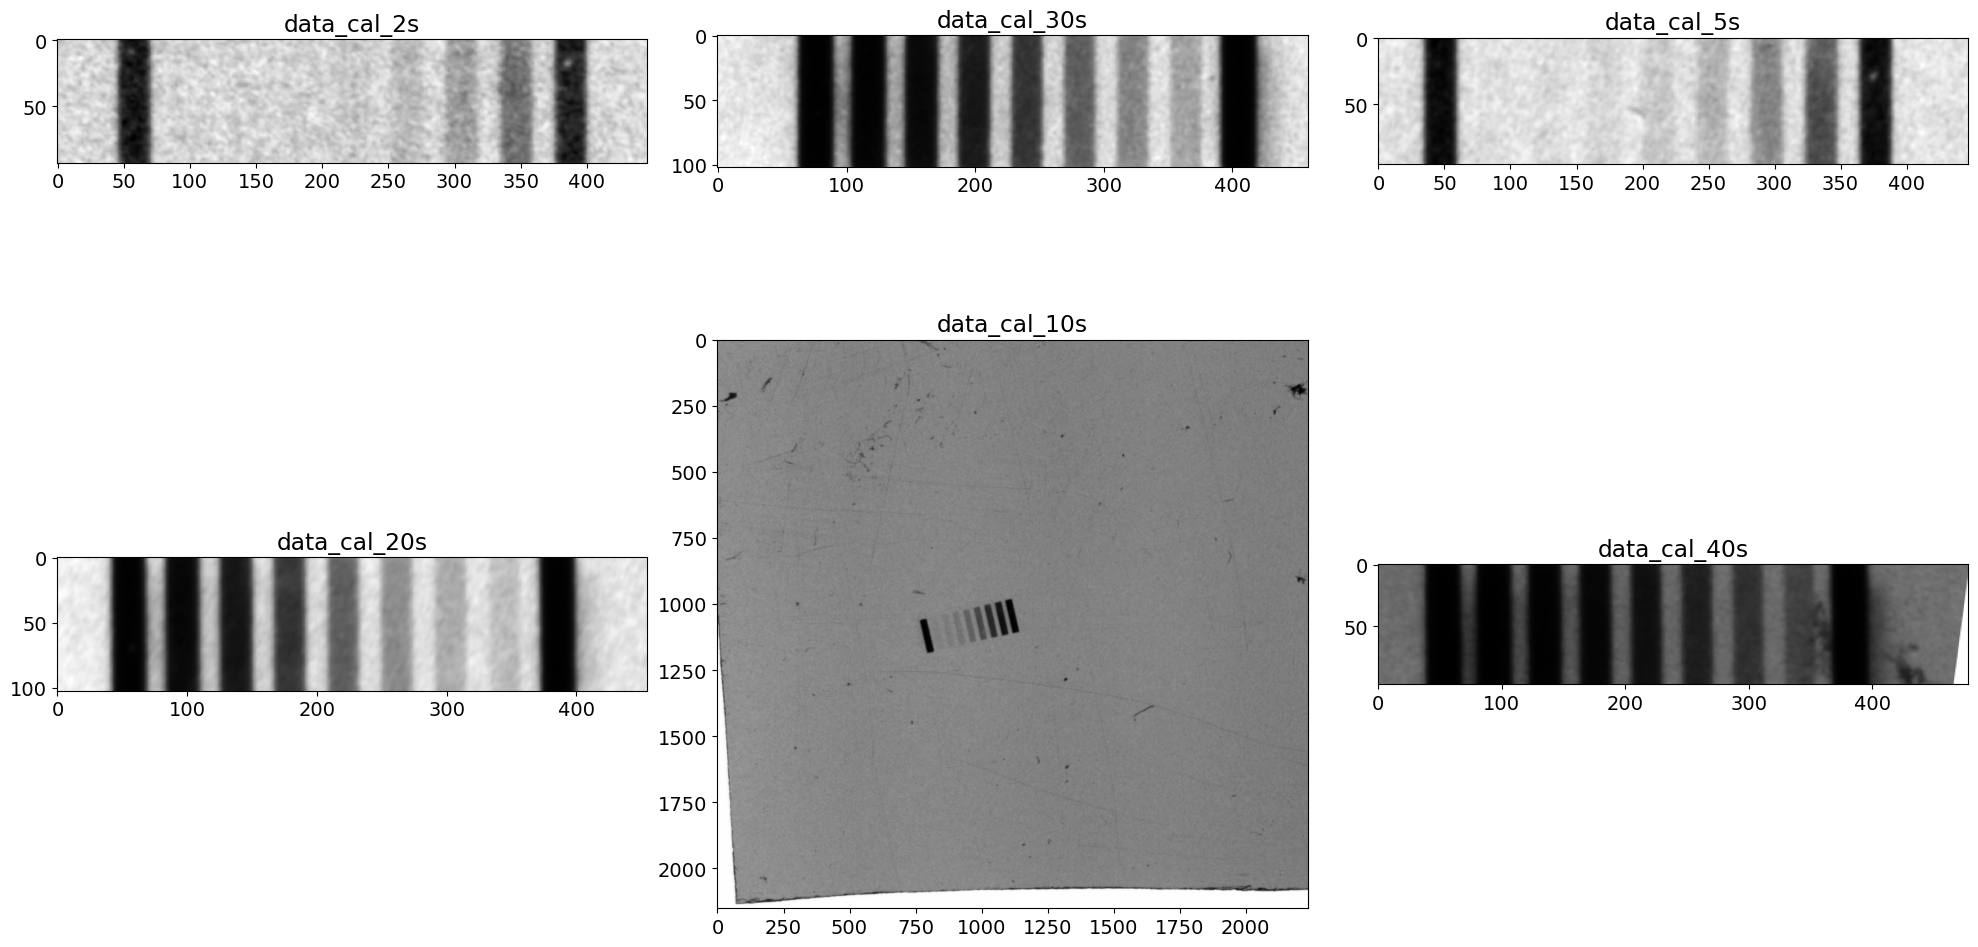

In [48]:
# Отфильтруем ключи, чтобы получить только те, которые начинаются с 'data_cal_'
data_keys = [key for key in calib_frames.keys() if key.startswith('data_cal_')]

# Количество колонок
columns = 3
# Вычисляем количество строк, необходимых для отображения всех изображений
rows = len(data_keys) // columns + (1 if len(data_keys) % columns else 0)

# Создаём фигуру для отображения
plt.figure(figsize=(20, rows * 6))

for i, key in enumerate(data_keys, 1):
    plt.subplot(rows, columns, i)
    plt.imshow(calib_frames[key][0], cmap='gray')
    plt.title(key)
    #plt.axis('off')

plt.tight_layout()
plt.show()

If we have some overexposed frames in which the attenuator steps clearly merge with each other, we delete them.
Sometimes they work good and it's better to check in the next steps if attenuator steps are really overexposed (in the case the second step is equely or more intence than the first one).

In [38]:
#That is how we can remove data of overexposed frames by exposure time
calib_frames = {k: v for k, v in calib_frames.items() if 'EXP. for instance "2m"' not in k}

calib_frames.keys()

dict_keys(['fits_cal_2s', 'data_cal_2s', 'fits_cal_30s', 'data_cal_30s', 'fits_cal_5s', 'data_cal_5s', 'fits_cal_20s', 'data_cal_20s', 'fits_cal_10s', 'data_cal_10s', 'fits_cal_40s', 'data_cal_40s'])

#### Rotation (manualy)

Sometimes tilt angle of image is very large (for instence, more than 45 degree). In the case we need to rotate it manualy.

In [ ]:
data_keys = [key for key in calib_frames.keys() if key.startswith('data_cal_')]
for i, key in enumerate(data_keys, 1):
        calib_frames[key][0] = rotate_image(calib_frames[key][0], theta=-5, crop=False) 
        #theta is angle to rotate image. Positive value - clockwise rotation, negative - counterclockwise.

# Отфильтруем ключи, чтобы получить только те, которые начинаются с 'data_cal_'
data_keys = [key for key in calib_frames.keys() if key.startswith('data_cal_')]

# Количество колонок
columns = 3
# Вычисляем количество строк, необходимых для отображения всех изображений
rows = len(data_keys) // columns + (1 if len(data_keys) % columns else 0)

# Создаём фигуру для отображения
plt.figure(figsize=(20, rows * 6))

for i, key in enumerate(data_keys, 1):
    plt.subplot(rows, columns, i)
    plt.imshow(calib_frames[key][0], cmap='gray')
    plt.title(key)
    #plt.axis('off')

plt.tight_layout()
plt.show()

#### Crop

We use Automaticaly crop ONLY if we do NOT have two or more calibration images on a frame.

##### Automaticaly

We need to crop images because there is too much space around important part (steps image). We can crop automaticaly using function `standart_crop`. The function will crop ALL frames.

In [ ]:
# For find out if cropping is okay we create additional variable to do not save changes
v = 0.4
h = 0.33
calib_frames_copy = copy.deepcopy(calib_frames) #copy.deepcopy() ensures that even nested objects are copied rather than becoming link.
calib_frames_preview = standart_crop(calib_frames_copy, part_to_crop_v=v, part_to_crop_h=h)


In [ ]:
#Now when we sure about cropping parametres we can save them using "rigth" variable
calib_frames = standart_crop(calib_frames,part_to_crop_v=v,part_to_crop_h=h)

##### Manually

If you need to do cropping for only one or a few images, please, do it manually. It may be important when you have 2 or more calibration images on one frame. In the case we have to separate them using manualy cropping.

It could be useful if there're very intense areas are not belong to attenuator steps.

In [ ]:
#That is how we can do it manually
#calib_frames["data_cal_30s"][0] = rotate_image(calib_frames["data_cal_30s"][0],theta=10)[0:1200]

#Firstly jus plot then crop
#plt.imshow(calib_frames["data_cal_30s"][0][0:250])
#plt.imshow(calib_frames["data_cal_5s"][0][200:410])



calib_frames["data_cal_30s"][0] = calib_frames["data_cal_30s"][0][0:250]
calib_frames["data_cal_5s"][0] = calib_frames["data_cal_5s"][0][200:410]

##### Separate

If we have two or more calibration images on a frame we should separate them manualy :'(

In [ ]:
# calib_frames["data_cal_10s_20s"] consist of elements
# 0 - data
# 1 - header
# 2 - array:
#    0 - file name (then we add the final exposure like "_10s")
#    1 - file extinxtion

# calib_frames["data_cal_10s"] = [calib_frames["data_cal_10s_20s"][0][0:600,300:1100], calib_frames["data_cal_10s_20s"][1], [calib_frames["data_cal_10s_20s"][2][0]+"_10s", calib_frames["data_cal_10s_20s"][2][1]]


In [ ]:
# Отфильтруем ключи, чтобы получить только те, которые начинаются с 'data_cal_'
data_keys = [key for key in calib_frames.keys() if key.startswith('data_cal_')]

# Количество колонок
columns = 3
# Вычисляем количество строк, необходимых для отображения всех изображений
rows = len(data_keys) // columns + (1 if len(data_keys) % columns else 0)

# Создаём фигуру для отображения
plt.figure(figsize=(20, rows * 6))

for i, key in enumerate(data_keys, 1):
    plt.subplot(rows, columns, i)
    plt.imshow(calib_frames[key][0], cmap='gray')
    plt.title(key)
    #plt.axis('off')

plt.tight_layout()
plt.show()

#### Removing of "bad" images

There could be "burned out" calibration frames. You can detect them by large dark aura around them, or by almost identity of step lines intensity even between the 4th and 1st lines. In the case we have to remove the frames.

In [ ]:
calib_frames.keys()

If we have some overexposed frames in which the attenuator steps clearly merge with each other, we delete them.
Sometimes they work good and it's better to check in the next steps if attenuator steps are really overexposed (in the case the second step is equely or more intence than the first one).

In [ ]:
#That is how we can remove data of overexposed frames by exposure time
calib_frames = {k: v for k, v in calib_frames.items() if 'EXP. for instance "2m"' not in k}

calib_frames.keys()

# Crop & rotate

In [ ]:
# Создаем список ключей для итерации, чтобы избежать изменения словаря во время итерации
keys_to_process = list(key for key in calib_frames.keys() if "_crop_rot" not in key and key.startswith('data_cal_'))

# Итерация по копии списка ключей
for key in keys_to_process:
    print("-------------",key)
    value = calib_frames[key][0]
    result = rotate_spectra_machine_vision(value,padding=40)  # Применение функции
    #padding - the number of pixels that should be cut from the found borders inwards, that is, reduce the image by a given number of pixels
    new_key = f"{key}_crop_rot"  # Формирование нового ключа
    calib_frames[new_key] = [result,calib_frames[key][1],calib_frames[key][2]]  # Добавление результата в словарь после итерации

Sometimes it could crop automaticaly not in normal way, so we unfortunatly have to crop again manualy.

In [ ]:
#plt.imshow(calib_frames["data_cal_10s_crop_rot"][0][:80])
#plt.imshow(calib_frames["data_cal_40s_crop_rot"][0][10:])


calib_frames["data_cal_10s_crop_rot"][0]  = calib_frames["data_cal_10s_crop_rot"][0][:80]
calib_frames["data_cal_40s_crop_rot"][0]  = calib_frames["data_cal_40s_crop_rot"][0][10:]

Let's see what we get us result of manual cropping

In [ ]:
# Фильтруем ключи, чтобы получить только те, что содержат '_crop_rot'
filtered_keys = [key for key in calib_frames if '_crop_rot' in key]

# Определяем количество колонок
num_columns = 3
# Вычисляем количество строк, необходимое для размещения всех изображений
num_rows = len(filtered_keys) // num_columns + (len(filtered_keys) % num_columns > 0)

# Создаём фигуру и оси
fig, axes = plt.subplots(num_rows, num_columns, figsize=(3*num_columns, 1.1*num_rows))
axes = axes.flatten()  # Преобразуем массив осей в одномерный

# Отображаем изображения
for i, key in enumerate(filtered_keys):
    axes[i].imshow(calib_frames[key][0], cmap='gray')  # Используем cmap='gray', если изображения в градациях серого
    axes[i].title.set_text(key.split("_")[2])
    axes[i].axis('off')  # Скрываем оси координат
    calib_frames[key][1]["DAT_CROP"] = datetime.now().strftime('%Y-%m-%dT%H:%M:%S')
    # Создаем FITS HDU (Header/Data Unit) с данными и заголовком
    hdu = fits.PrimaryHDU(data=calib_frames[key][0], header=calib_frames[key][1])

    # Создаем HDUList и сохраняем в файл
    hdul = fits.HDUList([hdu])

    # Сохраняем файл
    hdul.writeto(path_calib + calib_frames[key][2][0]+"_crop_rot"+calib_frames[key][2][1], overwrite=True)
    

# Скрываем лишние оси, если они есть
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Устанавливаем маленькие расстояния между изображениями
plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Уменьшаем расстояние между изображениями

# Показываем результат
plt.show()



# Find peaks

In [ ]:
# Создаем список ключей из уже обрезанных и выровненных кадров для поиска пиков,
#чтобы избежать изменения словаря во время итерации
keys_to_process = list(key for key in calib_frames.keys() if "_crop_rot" in key and "_crop_rot_peaks" not in key)
# Итерация по копии списка ключей
for key in keys_to_process:
    print(key)
    value = calib_frames[key][0]
    result = get_peaks(value,title=key)  # Применение функции
    new_key = f"{key}_peaks"  # Формирование нового ключа
    calib_frames[new_key] = result  # Добавление результата в словарь после итерации

$\textcolor{red}{IMPORTANT}$

If you see that real 1st peak was not found, but it started from the 2d peak, please, remove the date from dictionary.

In [ ]:
#Создание нового словаря без ключей, содержащих '4m'
calib_frames = {k: v for k, v in calib_frames.items() if '2m' not in k}

calib_frames.keys()

### Characteristic curve

In [ ]:
# Словарь для преобразования строк времени в секунды
time_to_seconds = {'s': 1, 'm': 60, 'h': 3600}

def time_str_to_sec(time_str):
    # Изменено регулярное выражение для учета дробных чисел
    matches = re.match(r"(\d+(\.\d+)?)([smh]?)", time_str)
    if matches:
        value, _, unit = matches.groups()  # Добавлено игнорирование неиспользуемой группы
        return float(value) * time_to_seconds[unit]
    return 0  # Возвращаем 0, если формат не соответствует ожиданиям

# Создание списка массивов, включая время (в секундах) и сами массивы
arrays_with_times = []
for key, array in calib_frames.items():
    if "_crop_rot_peaks" in key:
        # Извлечение времени экспозиции из названия ключа
        time_part = re.search(r"_([0-9]+(\.[0-9]+)?[smh]?)_", key)
        if time_part:
            time_in_seconds = time_str_to_sec(time_part.group(1))
            arrays_with_times.append((time_in_seconds, key, array[:-1]))

# Сортировка списка по времени экспозиции в убывающем порядке
arrays_with_times.sort(reverse=True, key=lambda x: x[0])
exp_times =  [item[0]for item in arrays_with_times][::-1]

sort_arrays = []
for i in range(len(arrays_with_times)):
    sort_arrays.append(arrays_with_times[i][-1])

In [ ]:
x_array=[]
x_array.append(mag_before_1972)

y_array = []
y_array.append(sort_arrays[0])


x_array_full = []
y_array_full = []

for i in range(0,len(sort_arrays)):
    x,y = shift_mag_x_array(sort_arrays,i,mag)
    x_array_full.append(x)
    y_array_full.append(y)

# Filter out the empty arrays and concatenate the rest
x_array_full = [arr for arr in x_array_full if arr.size > 0]
y_array_full = [arr for arr in y_array_full if arr.size > 0]

if x_array_full:  # Check if there are any non-empty arrays to concatenate
    x_array_full = np.concatenate(x_array_full)
    y_array_full = np.concatenate(y_array_full)
    
    plt.figure(figsize=(8, 4))
    plt.scatter(x_array_full, y_array_full)  # Example y-values
    plt.xlabel("Magnitude, m")
    plt.ylabel("Optical density")
    plt.show()

In [ ]:
intensity, opt_dens = mean_deviation(x_array_full, y_array_full)

In [ ]:
best_poly,polynomial_extrapolate,extrapolation_coefficients,opt_dens_min = poly_mse_new_1(opt_dens,intensity,date_fit)

## Save polynomial to csv archive

In [ ]:
path_csv = os.getcwd()+"/"

cal_ploy_csv = pd.read_csv(path_csv+"calibration_polynomial_archive.csv", encoding='utf-8')

cal_ploy_csv

In [ ]:
# Новая строка для добавления
if date_fit in np.array(cal_ploy_csv["date_fit"]):
    print("Calibration data alredy exist in archive")
else:
    new_row = {'id': generate_next_unique_id(cal_ploy_csv), 
               'files_name': ','.join(map(str, np.array(calib_frames_list))), 
               'exp_times_sec': ','.join(map(str, np.array(exp_times))), 
               'date_fit': date_fit, 
               'main_poly': ','.join(map(str, np.array(best_poly))),
               'extra_poly': ','.join(map(str, np.array(extrapolation_coefficients))),
               'opt_dens_min': opt_dens_min}
    
    # Добавление новой строки в DataFrame
    cal_ploy_csv = pd.concat([cal_ploy_csv, pd.DataFrame([new_row])], ignore_index=True)
    cal_ploy_csv.to_csv(path_csv+"calibration_polynomial_archive.csv",index=False)

cal_ploy_csv.tail()

[beginning](#beginning)